In [2]:
import random

SAMPLE_RATE = 22016
DURATION = 1
OFFSET=10

SAMPLE_LENGTH = SAMPLE_RATE * DURATION


data_amount = 7000 # Сколько файлов (записей) взять для обучения и тестирования 
train_amount_percent = 0.8 # процент обучающей выборки из всех данных


learning_rate = 0.001
epochs = 50
batch_size = 64


use_Trained_model = True # Чтобы загрузить имеющуюся модель нужно ставить в True. Чтобы тренировать - False
new_model_name = "model" + random.randint(0, 100000).__str__() + ".pt" # Имя файла в который сохранится модель
used_model = "model_no_scaler.pt" # Модель которая будет использована на валидационной выборке

## Загрузчик данных

In [3]:
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch
import random
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np
import joblib
import os.path
from torch.utils.data import DataLoader, Subset


def getPathes():
    path = "resources\\fma_small"
    pathes = []

    for subdir in os.listdir(path):
        if subdir == 'README.txt' or subdir == 'checksums': continue
        f_path = path+"\\"+subdir
        for file in os.listdir(f_path):
            if file.endswith(".mp3"):
                pathes.append(os.path.join(f_path, file))

    return pathes

def scaler( lst:list) -> list:
        mx = abs(max(lst, key=abs))
        if mx != 0:
            lst = [item*(1/mx) for item in lst]
        return  np.array(lst) 

pathes = getPathes()

class CustomAudioDataset(Dataset):
    def __init__(self, pathes):
        self.scaler_filename = "scaler.save"
        self.pathes = pathes
        self.min_len = SAMPLE_LENGTH
        self.is_use_fft = False

    def __len__(self):
        return self.pathes.__len__()

    def __getitem__(self, idx:int):
        audio = self.loader(idx)
        audio = torch.from_numpy(audio[:SAMPLE_LENGTH]).type(torch.float)
        return np.array([audio])
    
    def loader(self,ind:int): # Загрузка mp3 файла в виде list
        try:
            y, sr = librosa.load(self.pathes[ind], duration=DURATION, sr=SAMPLE_RATE, offset=OFFSET) # Загружает mp3 как массив           
            y= scaler(y)
            return y
        except:
            print("error: " + self.pathes[ind].__str__())

    
    

if use_Trained_model == False:   
    random.shuffle(pathes)
    part_pathes = pathes[:data_amount]
    train_end_index = round(part_pathes.__len__()*train_amount_percent)
    train_ds = CustomAudioDataset(part_pathes[:train_end_index]) # Обучающая выборка
    test_ds = CustomAudioDataset(part_pathes[train_end_index+1:]) # Тестовая выборка


    item, _ = librosa.load(pathes[1], duration=DURATION, sr=SAMPLE_RATE, offset=OFFSET)
    plt.plot(item)
    plt.show()

    item = train_ds.__getitem__(1)
    plt.plot(item[0])
    plt.show()

    train_dataset = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
    test_dataset = DataLoader(test_ds,batch_size=batch_size,shuffle=True)

# Автоэнкодер

In [4]:
# Выбор устройства для обучения. Почему-то torch.cuda.is_available() всегда False. При этом считает на видеокарточке

device = torch.device("cuda")

In [5]:
import torch.nn as nn

loss_function = nn.MSELoss(reduction='sum')

In [6]:
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from collections import OrderedDict

# Автоэнкодер
class VAE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(1, 64, kernel_size=512, stride=256, padding=0)), # сверточный слой
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv1d(64, 32, kernel_size=1, stride=1)), # сверточный слой
            ('relu2', nn.ReLU(inplace=True)), 
        ]))

        self.decoder_model = nn.Sequential(OrderedDict([
            ('convT2', nn.ConvTranspose1d(
                32, 64, kernel_size=1, stride=1, output_padding=0)),
            ('reluT2', nn.ReLU(inplace=True)),
            ('convT1', nn.ConvTranspose1d(
                64, 1, kernel_size=512, stride=256, output_padding=0)),
        ]))

    def forward(self, inputs):

        encoded_data = self.forward_encoder(inputs)
        decoded_data = self.forward_decoder(encoded_data)

        return decoded_data

    def forward_encoder(self, inputs):
        return self.encoder_model(inputs)

    def forward_decoder(self, inputs):
        return self.decoder_model(inputs)



In [7]:
# Оптимизатор

if use_Trained_model == False:
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение

In [8]:
import gc
import time 

# Функция обучения
def train(epoch):
    model.train()
    train_loss = 0
    epoch_start_time = time.time()  

    for batch_idx, data in enumerate(train_dataset):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 4 == 0:
            print(f"Эпоха {epoch} [{batch_idx * data.__len__()}/{train_dataset.dataset.__len__()} "
                  f"({100. * batch_idx / train_dataset.__len__():.0f}%)]\tПотеря: {loss.item() / data.__len__():.4f}")

    epoch_end_time = time.time()  
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"====> Эпоха {epoch} Средняя потеря: {train_loss / train_dataset.dataset.__len__():.4f} "
          f"Время: {epoch_duration:.2f} секунд")

# Функция тестирования
def test():
    model.eval()
    test_loss = 0
    test_start_time = time.time()  
    with torch.no_grad():
        for data in train_dataset:
            data = data.to(device)
            recon = model(data)
            test_loss += loss_function(recon, data).item()

    test_end_time = time.time()  
    test_duration = test_end_time - test_start_time
    test_loss /= train_dataset.dataset.__len__()
    print(f"====> Тестовая потеря: {test_loss:.4f} Время: {test_duration:.2f} секунд")
    return test_loss

if use_Trained_model == False:
    script_start_time = time.time()
    test_loses = []
    for epoch in range(1, epochs + 1):
        gc.collect()
        train(epoch)
        ls = test()
        test_loses.append(ls)

In [9]:
if use_Trained_model == False:
    torch.save(model.state_dict(), new_model_name)

In [10]:
if use_Trained_model:
    model = VAE()
    model.load_state_dict(torch.load("models/" + used_model, weights_only=True))

### График изменения потери

In [11]:
if use_Trained_model == False:
    plt.plot(test_loses)
    plt.show()

# Сравнение до и после энкодинга на валидационной выборке

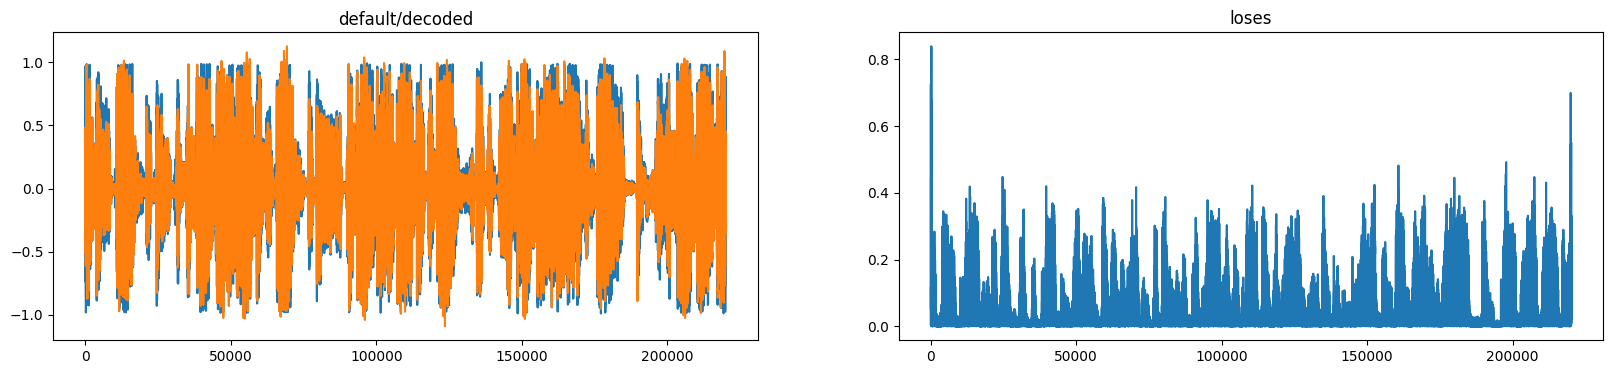

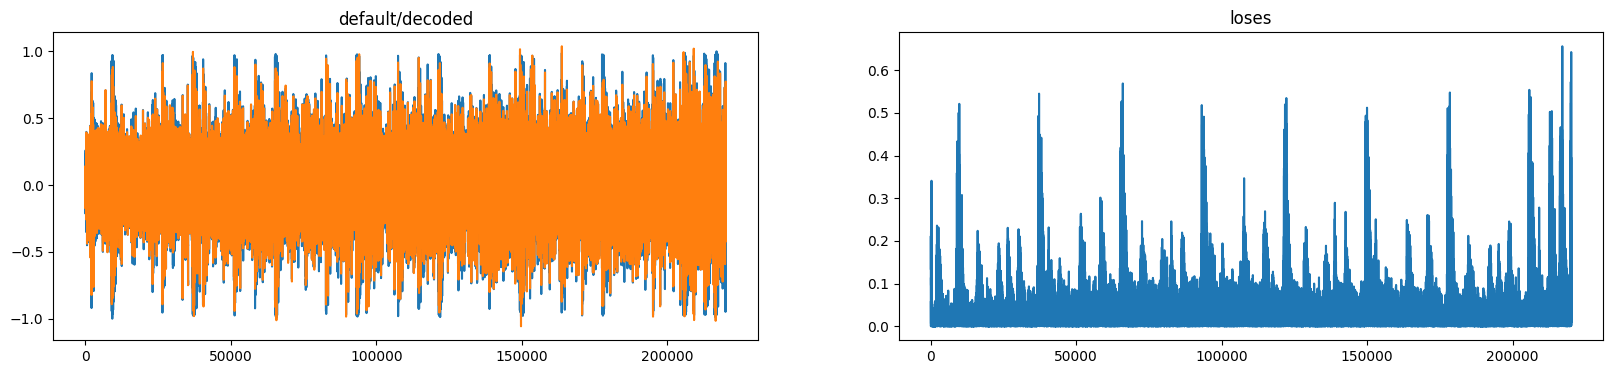

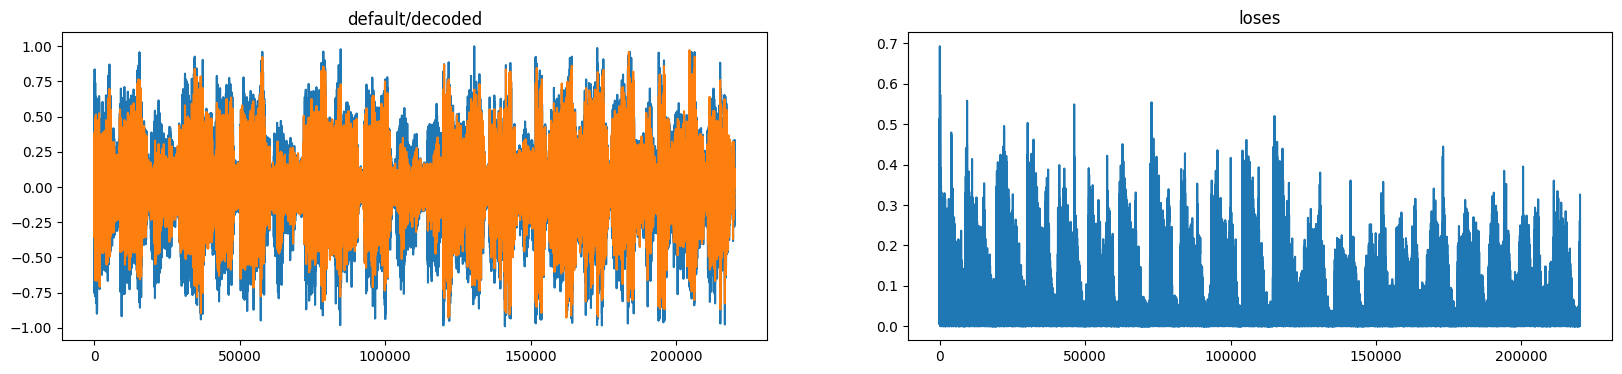

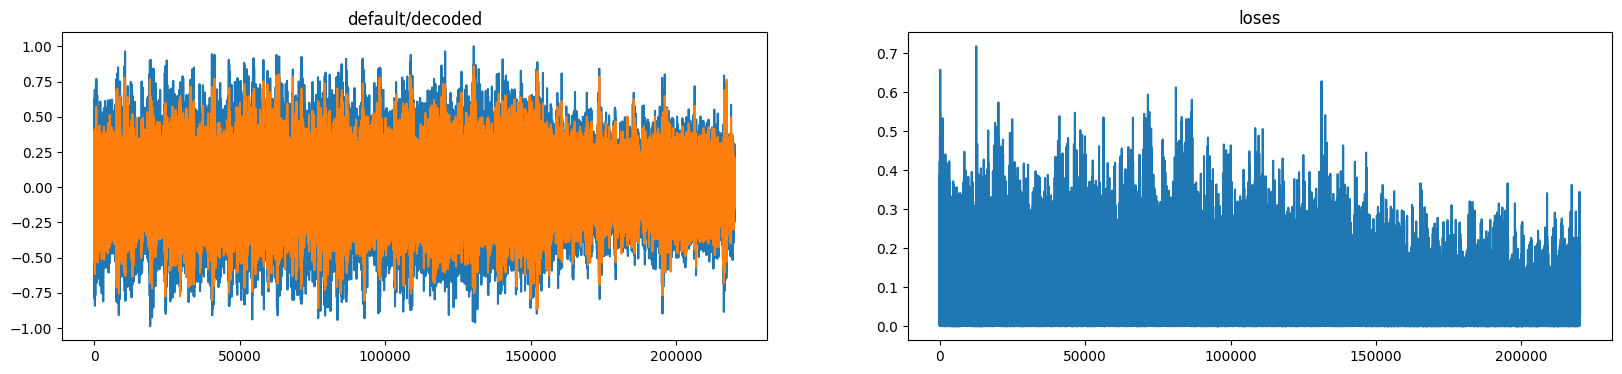

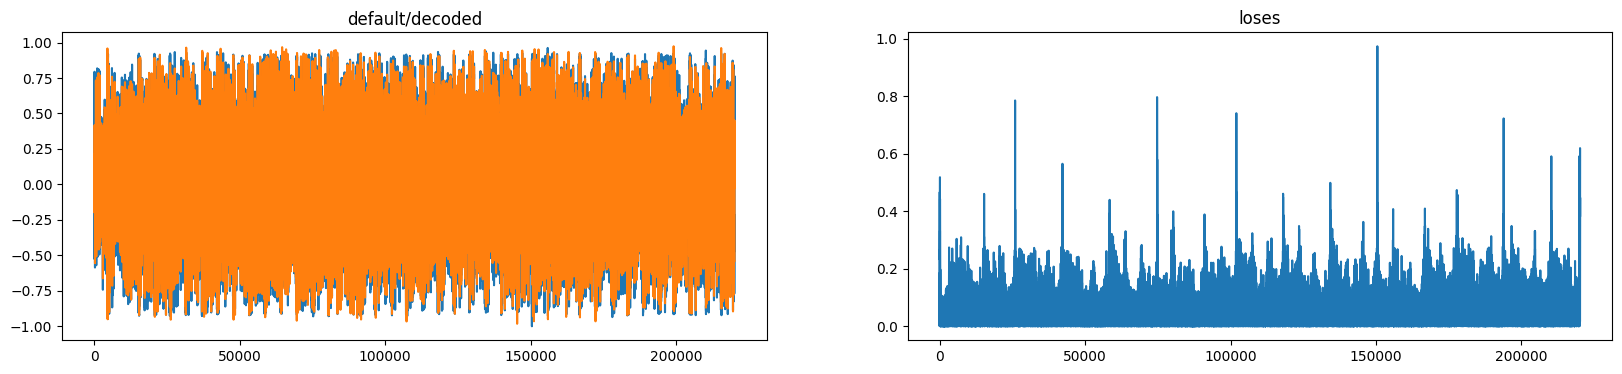

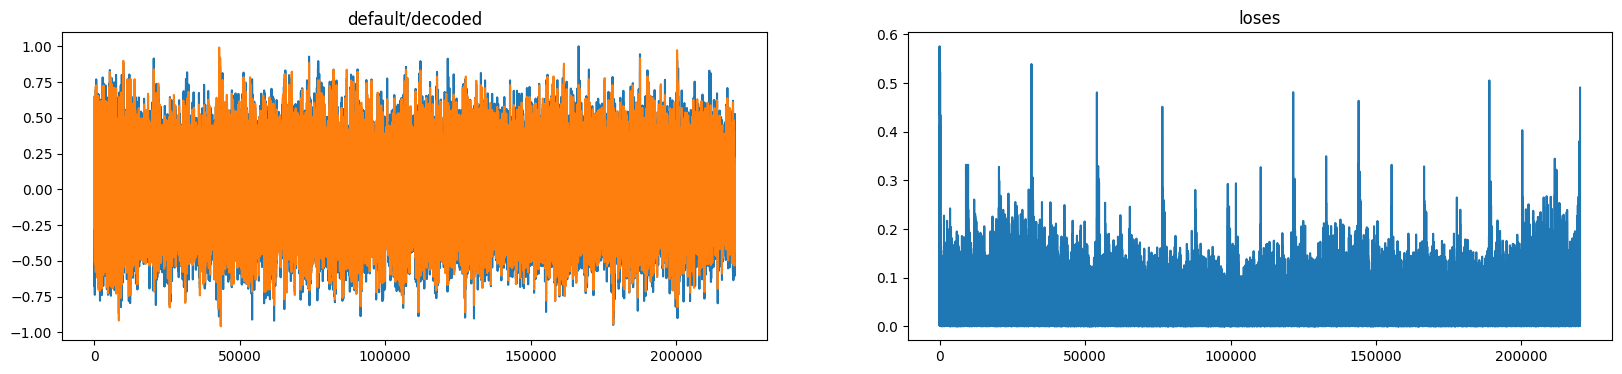

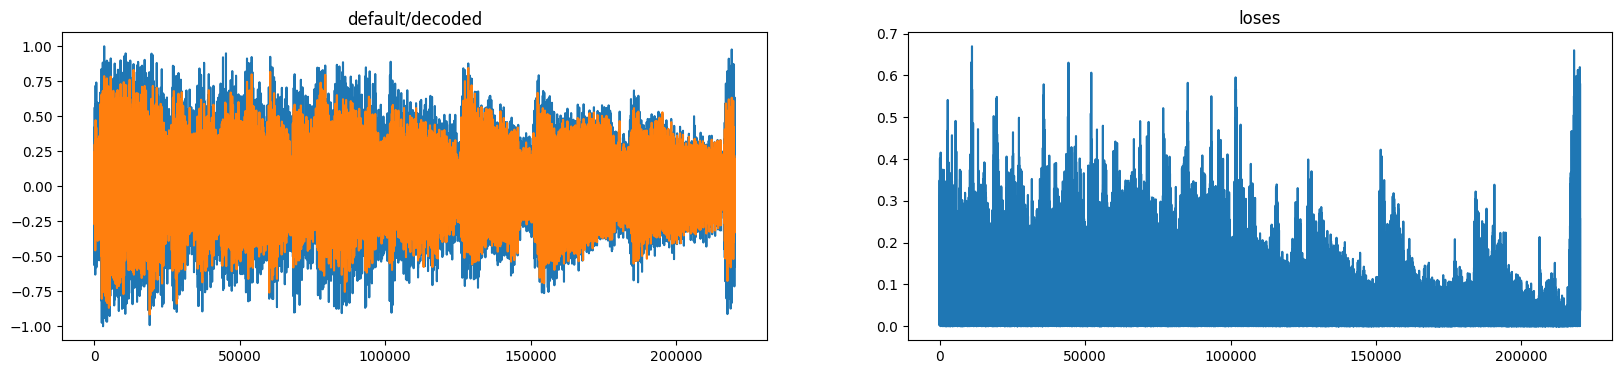

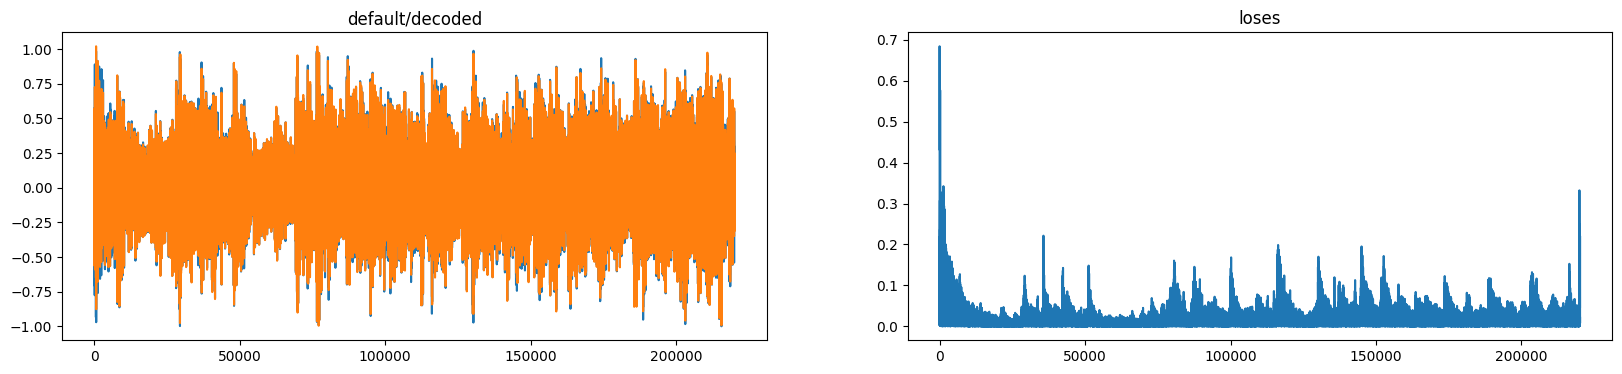

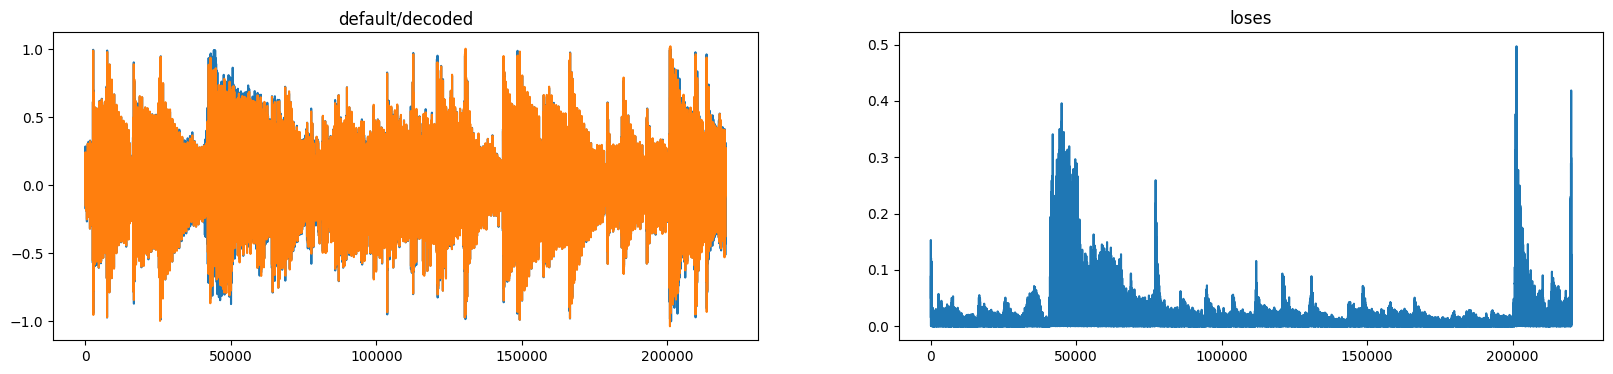

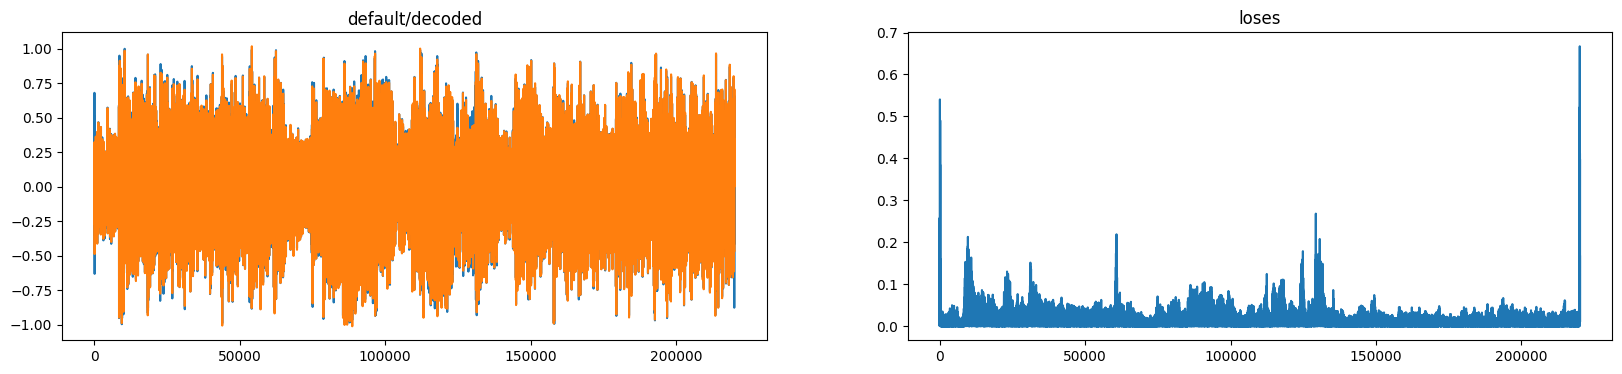

In [ ]:
model.eval()

DURATION = 10
SAMPLE_LENGTH = SAMPLE_RATE * DURATION

max_displaying_items = 10

def loader(startInd: int,amount:int):
    loaded_data = []
    for path in pathes[startInd:startInd + amount]:
        y, sr = librosa.load(path, duration=DURATION, sr=SAMPLE_RATE, offset=5)
        loaded_data.append(y)
    return loaded_data

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

y = loader(7500, max_displaying_items)
s_y = [scaler(item) for item in y]
decoded = []
encoded = []
for i, item in enumerate(s_y):
    y_tensor = torch.FloatTensor(item).view(-1, SAMPLE_LENGTH)
    enc = model.forward_encoder(y_tensor) # сжимаю аудио
    encoded.append(enc)
    dec = model.forward_decoder(enc) # декодирую аудио. Сжимается в 4 раза
    decoded.append(dec[0])




def draw_one_plot_line(default, decoded):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[20, 4])   

     # график сравнение декодированого и оригинального спектра
    ax1.plot(default)
    ax1.plot(decoded.tolist())
    ax1.set_title("default/decoded") 

    # График потерь
    def_abs = [abs(x) for x in default] #
    dec_abs = [abs(x) for x in decoded.tolist()]
    loses = [abs(def_abs[i] - dec_abs[i]) for i,x in enumerate(default)]
    ax2.plot(loses)
    ax2.set_title("loses")



for i in range(0, max_displaying_items):
    draw_one_plot_line(s_y[i], decoded[i])

Создаю wav файлы

In [13]:
import soundfile as sf

ind = 0

def save_mp3(y, filename):
    sf.write(filename, y, 22016)

save_mp3(decoded[ind].tolist(), "decoded.wav")
torch.save(encoded[ind], "compresed.pt")
save_mp3(y[ind], "original.wav")